# Bayes by Backprop

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('GPU device not found. Using CPU')
else:
  print('Found GPU: {}'.format(tf.test.gpu_device_name()))

# enable Tensorflow eager mode (only for tf version 1.13)
# tf.enable_eager_execution()

Tensorflow Version: 2.0.0-beta0
Tensorflow Probability Version: 0.8.0-dev20190617
Found GPU: /device:GPU:0


In [3]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [4]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [5]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

x_train, y_train, x_test, y_test = (x_train, y_train, x_test, y_test)

In [6]:
# Bayes by Backprop parameters

# model save file
model_save_file = "./models/distribution_lambda.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# batch size for training
batch_size = 128

# training epochs 
epochs = 15

# GloVe Word Embedding

In [7]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [8]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [9]:
def create_model():
    model = tfk.Sequential()
    
    model.add(tfkl.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    
    for i in range(len(n_hidden)):
        model.add(tfkl.Dense(n_hidden[i], activation="relu"))
    
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1 + 1))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.5 * t[...,1:]))))
    
    
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    model.compile(optimizer=tfk.optimizers.Adam(0.001), loss=negloglik, metrics=['acc'])

    return model

try:
    model = tfk.models.load_model(model_save_file)
    print("using saved model")
except:
    model = create_model()
    print("model has not been trained")
model.summary()

model has not been trained
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dense (Dense)                (None, 2697, 64)          3264      
_________________________________________________________________
dense_1 (Dense)              (None, 2697, 64)          4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2697, 32)          2080      
_________________________________________________________________
flatten (Flatten)            (None, 86304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 172610    
_________________________________________________________________
distribution_lambda (Distrib 

In [ ]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb
tb_callback = tfk.callbacks.TensorBoard(log_dir='logs') 
model_checkpoint_cb = tfk.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=1, 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      mode='auto')

model.fit(x_train_padded, y_train, validation_split=0.05, epochs=epochs, batch_size=batch_size, callbacks=[tb_callback, model_checkpoint_cb])

Train on 23750 samples, validate on 1250 samples
Epoch 1/15
23680/23750 [============================>.] - ETA: 0s - loss: 0.8303 - acc: 0.5113
Epoch 00001: val_loss improved from inf to 0.63835, saving model to ./models/distribution_lambda.h5
23750/23750 [==============================] - 13s 536us/sample - loss: 0.8299 - acc: 0.5111 - val_loss: 0.6383 - val_acc: 0.5560
Epoch 2/15
23680/23750 [============================>.] - ETA: 0s - loss: 0.5563 - acc: 0.6130
Epoch 00002: val_loss improved from 0.63835 to 0.52964, saving model to ./models/distribution_lambda.h5
23750/23750 [==============================] - 12s 492us/sample - loss: 0.5571 - acc: 0.6127 - val_loss: 0.5296 - val_acc: 0.6536
Epoch 3/15
23680/23750 [============================>.] - ETA: 0s - loss: 0.4270 - acc: 0.6862
Epoch 00003: val_loss improved from 0.52964 to 0.51191, saving model to ./models/distribution_lambda.h5
23750/23750 [==============================] - 12s 501us/sample - loss: 0.4269 - acc: 0.6865 - val

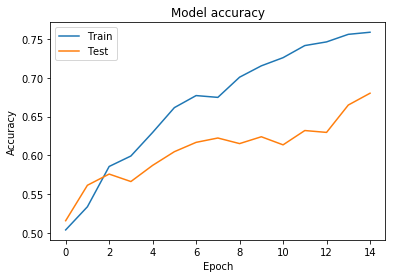

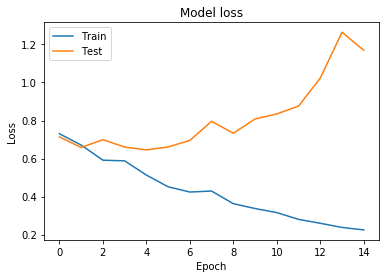

In [129]:
if hasattr(model, "history"):
    history = model.history

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [127]:
preds = model(x_test_padded[:20])
[print(mean.numpy(), std.numpy()) for (mean, std) in zip(preds.mean(), preds.stddev())]

[0.37982348] [0.36954394]
[0.8028181] [0.35194165]
[1.1545851] [0.19344607]
[0.45221096] [0.28316417]
[0.35211736] [0.38696972]
[0.25735107] [0.31997412]
[0.4514123] [0.23518147]
[0.09308261] [0.34894997]
[0.49045205] [0.32704675]
[0.5549608] [0.24733195]
[0.73718566] [0.32193124]
[0.45776546] [0.35267773]
[0.5571943] [0.25585285]
[0.33204824] [0.211839]
[0.9020314] [0.32680866]
[-0.34657428] [0.33330733]
[0.85236025] [0.3550978]
[0.5285315] [0.3475883]
[0.41470498] [0.34902698]
[0.53296566] [0.35011464]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]